# Read Results

In [24]:
import pickle

with open("cache/dpf_mvsa_single_results.pkl", "rb") as f:
    results = pickle.load(f)

# RETRIEVE  Varibles from results
train_probs_text   = results["train_probs_text"]
train_probs_image  = results["train_probs_image"]

val_probs_text     = results["val_probs_text"]
val_probs_image    = results["val_probs_image"]

test_probs_text    = results["test_probs_text"]
test_probs_image   = results["test_probs_image"]

y_train_int = results["y_train_int"]
y_val_int   = results["y_val_int"]
y_test_int  = results["y_test_int"]

beta  = results["beta"]
topk  = results["topk"]
delta = results["delta"]

In [2]:
import numpy as np
import xgboost as xgb
import time
from sklearn.ensemble import ExtraTreesClassifier
def dynamic_weight_topk_adaptive(prob1, prob2, beta=0.1, topk=2, delta=1e-4):
    """
    Calculate dynamic weights for two modalities using Top-k Approximate Rényi-2 entropy
    with adaptive epsilon regularization for numerical stability.

    Args:
        prob1 (ndarray): Text modality predicted probabilities, shape (n_samples, n_classes)
        prob2 (ndarray): Image modality predicted probabilities, shape (n_samples, n_classes)
        beta (float): Temperature scaling factor.
        topk (int): Number of top probabilities to consider for entropy approximation.
        delta (float): Scaling factor for adaptive epsilon, relative to maximum squared probability.

    Returns:
        weights (ndarray): Normalized modality weights, shape (n_samples, 2)
    """
    # Select Top-k largest probabilities
    topk_prob1 = np.sort(prob1, axis=1)[:, -topk:]  # shape: (n_samples, topk)
    topk_prob2 = np.sort(prob2, axis=1)[:, -topk:]

    # Compute adaptive epsilon based on maximum p² in Top-k
    max_p2_text = np.max(topk_prob1**2, axis=1, keepdims=True)  # shape: (n_samples, 1)
    max_p2_image = np.max(topk_prob2**2, axis=1, keepdims=True)

    adaptive_eps_text = delta * max_p2_text  # epsilon for text modality
    adaptive_eps_image = delta * max_p2_image  # epsilon for image modality

    # Compute energy (negative log collision probability)
    energy_text = -np.log(np.sum(topk_prob1**2, axis=1, keepdims=True) + adaptive_eps_text).flatten()
    energy_image = -np.log(np.sum(topk_prob2**2, axis=1, keepdims=True) + adaptive_eps_image).flatten()

    # Compute normalized weights via Gibbs-style softmax
    energies = np.vstack([energy_text, energy_image]).T  # shape: (n_samples, 2)
    weights = np.exp(-beta * energies)
    weights /= np.sum(weights, axis=1, keepdims=True)

    return weights

def enhanced_dynamic_fusion_topk_adaptive(probs_text, probs_image, beta=0.1, topk=2, delta=1e-4):
    """
    Perform enhanced fusion by dynamically weighting two modalities and concatenating
    their weighted outputs, preserving modality-specific information.

    Args:
        probs_text (ndarray): Text modality predicted probabilities, shape (n_samples, n_classes)
        probs_image (ndarray): Image modality predicted probabilities, shape (n_samples, n_classes)
        beta (float): Temperature scaling factor.
        topk (int): Top-k approximation size.
        delta (float): Adaptive epsilon scaling factor.

    Returns:
        enhanced_fused_probs (ndarray): Concatenated weighted probability vectors, shape (n_samples, 2*n_classes)
    """
    weights = dynamic_weight_topk_adaptive(probs_text, probs_image, beta, topk, delta)
    fused_text = weights[:, 0:1] * probs_text  # weight applied to text probabilities
    fused_image = weights[:, 1:2] * probs_image  # weight applied to image probabilities
    enhanced_fused_probs = np.concatenate([fused_text, fused_image], axis=1)
    return enhanced_fused_probs
wx = dynamic_weight_topk_adaptive(
    train_probs_text,
    train_probs_image,
    beta,
    topk,
    delta
)


In [4]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# # 4. Global Fusion：Combine Text(3) + Image(3) -> 6 Dimensions
########################################
beta = 1.1
topk=2
delta =1e-2

# 4. Dynamic Fusion
X_train_global = enhanced_dynamic_fusion_topk_adaptive(train_probs_text, train_probs_image, beta, topk, delta)
X_val_global   = enhanced_dynamic_fusion_topk_adaptive(val_probs_text,   val_probs_image, beta, topk, delta)
X_test_global  = enhanced_dynamic_fusion_topk_adaptive(test_probs_text,  test_probs_image, beta, topk, delta)
print("Dynamic Fusion Feature shape (train):", X_train_global.shape)
# 5. Global Classifier
global_clf = xgb.XGBClassifier(300, max_depth=5, random_state=42)
global_clf.fit(X_train_global, y_train_int)

# 测试集
test_pred = global_clf.predict(X_test_global)
print("Test Accuracy:", accuracy_score(y_test_int, test_pred))
print("Test Classification Report:")
print(classification_report(y_test_int, test_pred,
                            digits=4,
                            target_names=['negative','neutral','positive']))


Dynamic Fusion Feature shape (train): (3895, 6)
Test Accuracy: 0.5585215605749486
Test Classification Report:
              precision    recall  f1-score   support

    negative     0.3571    0.1299    0.1905        77
     neutral     0.6196    0.7734    0.6880       278
    positive     0.4196    0.3561    0.3852       132

    accuracy                         0.5585       487
   macro avg     0.4655    0.4198    0.4212       487
weighted avg     0.5239    0.5585    0.5273       487



# Effect of β on Instance-Level Modality Weight Distribution 
This visualization makes the fusion behavior interpretable by showing how modality weights are distributed across individual samples.

This figure shows how $\beta$ (the Control Coefficient) changes fusion weights for text and image:Low $\beta$ $\rightarrow$ Uniformity: Weights are balanced. Both modalities have similar influence on every sample.High $\beta$ $\rightarrow$ Polarization: The model "decides" more aggressively.Confident samples $\uparrow$ (Weights increase)Uncertain samples $\downarrow$ (Weights are suppressed)Summary: Increasing $\beta$ "sharpens" the choice, forcing a clear distinction between reliable and unreliable data.

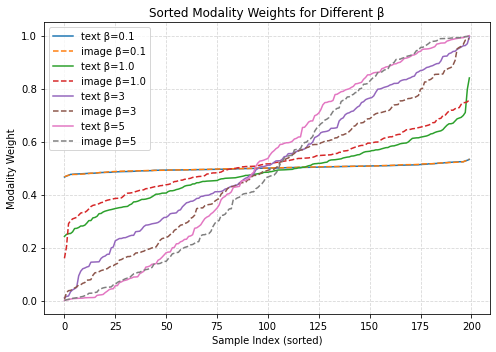

In [6]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
for b in betas:
    w = simulate_weights(b, n_samples=200)
    # Seperate
    txt = np.sort(w[:,0])
    img = np.sort(w[:,1])
    # Two curve，text (line)，image (dot line)
    plt.plot(txt,       label=f"text β={b}")
    plt.plot(img, linestyle="--", label=f"image β={b}")

plt.xlabel("Sample Index (sorted)")
plt.ylabel("Modality Weight")
plt.title("Sorted Modality Weights for Different β")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# Sorted Instance-Level Modality Weight Distribution (β=1.0)

The sorted curves provide a clear, global view of the weighting behavior without relying on individual examples. They make it easy to verify that fusion is not static, and that modality influence changes systematically across samples in a transparent and traceable way.

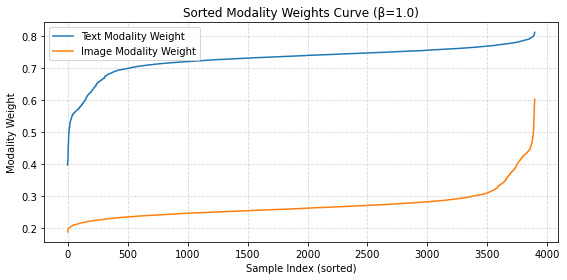

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- DEF dynamic_weight_topk_adaptive ---
def dynamic_weight_topk_adaptive(prob1, prob2, beta=0.1, topk=2, delta=1e-4):
    topk_prob1 = np.sort(prob1, axis=1)[:, -topk:]
    topk_prob2 = np.sort(prob2, axis=1)[:, -topk:]
    max_p2_text  = np.max(topk_prob1**2, axis=1, keepdims=True)
    max_p2_image = np.max(topk_prob2**2, axis=1, keepdims=True)
    eps_text  = delta * max_p2_text
    eps_image = delta * max_p2_image
    e_text  = -np.log(np.sum(topk_prob1**2, axis=1, keepdims=True) + eps_text).flatten()
    e_image = -np.log(np.sum(topk_prob2**2, axis=1, keepdims=True) + eps_image).flatten()
    E = np.vstack([e_text, e_image]).T
    w = np.exp(-beta * E)
    w /= w.sum(axis=1, keepdims=True)
    return w

# --- trial ---
# train_probs_text  = np.random.rand(200, 5)
# train_probs_image = np.random.rand(200, 5)

# Calculate Dynamic Weighting
weights = dynamic_weight_topk_adaptive(train_probs_text, train_probs_image, beta=1.0, topk=2, delta=1e-4)
text_weights  = weights[:, 0]
image_weights = weights[:, 1]

# Sorting
text_sorted  = np.sort(text_weights)
image_sorted = np.sort(image_weights)

# Drawing
plt.figure(figsize=(8, 4))
plt.plot(text_sorted, label='Text Modality Weight')
plt.plot(image_sorted, label='Image Modality Weight')
plt.xlabel('Sample Index (sorted)')
plt.ylabel('Modality Weight')
plt.title('Sorted Modality Weights Curve (β=1.0)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


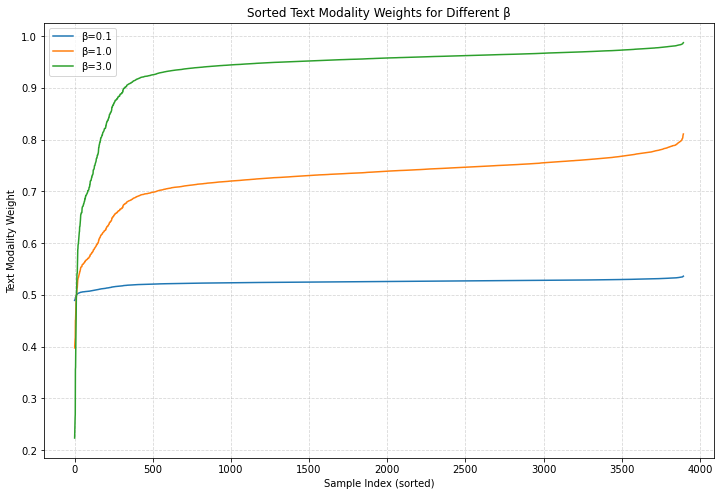

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def dynamic_weight_topk_adaptive(prob1, prob2, beta=0.1, topk=2, delta=1e-4):
    
    topk_prob1 = np.sort(prob1, axis=1)[:, -topk:]
    topk_prob2 = np.sort(prob2, axis=1)[:, -topk:]
    max_p2_text  = np.max(topk_prob1**2, axis=1, keepdims=True)
    max_p2_image = np.max(topk_prob2**2, axis=1, keepdims=True)
    eps_text  = delta * max_p2_text
    eps_image = delta * max_p2_image
    energy_text  = -np.log(np.sum(topk_prob1**2, axis=1, keepdims=True) + eps_text).flatten()
    energy_image = -np.log(np.sum(topk_prob2**2, axis=1, keepdims=True) + eps_image).flatten()
    E = np.vstack([energy_text, energy_image]).T
    W = np.exp(-beta * E)
    W /= np.sum(W, axis=1, keepdims=True)
    return W


# Pre-setting values
betas = [0.1, 1.0, 3.0]

plt.figure(figsize=(12, 8))
for beta in betas:
    weights = dynamic_weight_topk_adaptive(
        train_probs_text, train_probs_image,
        beta=beta, topk=2, delta=1e-4
    )
    w_text_sorted = np.sort(weights[:, 0])
    plt.plot(w_text_sorted, label=f'β={beta}')

plt.xlabel('Sample Index (sorted)')
plt.ylabel('Text Modality Weight')
plt.title('Sorted Text Modality Weights for Different β')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# Fusion weights shifting between modalities
#### Inspect the internal arbitration behavior of the fusion rule.
Same data with Fig.5 in the REPORT

This figure is used to verify that the fusion mechanism performs consistent, instance-level reliability arbitration, and to show how β controls the sharpness of this trade-off in a transparent and traceable way.

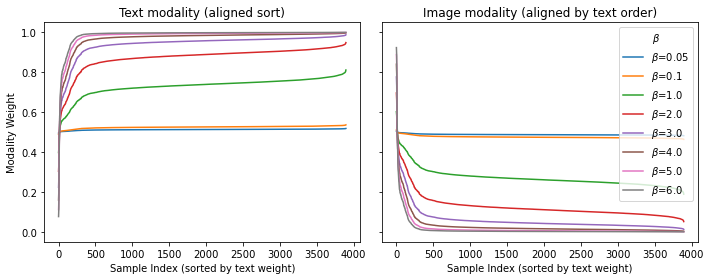

In [9]:
# 1) Real Weights in the data（ ）
betas = [0.05,0.1, 1.0,2.0, 3.0,4.0,5.0,6.0]  # 5
W = {b: dynamic_weight_topk_adaptive(train_probs_text, train_probs_image,
                                     beta=b, topk=2, delta=1e-4) for b in betas}

# 2) Sorting（eg text sorting by weights）
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
for b in betas:
    w = W[b]
    idx = np.argsort(w[:,0])         #  text weight sorting
    txt = w[idx, 0]                  # Sorted text weighting
    img = w[idx, 1]                  # 
    axes[0].plot(txt, label=fr"$\beta$={b}")
    axes[1].plot(img, label=fr"$\beta$={b}")

axes[0].set_title("Text modality (aligned sort)")
axes[1].set_title("Image modality (aligned by text order)")
for ax in axes: ax.set_xlabel("Sample Index (sorted by text weight)")
axes[0].set_ylabel("Modality Weight")
axes[1].legend(title=r"$\beta$")
plt.tight_layout(); plt.show()

In [18]:
import numpy as np
import matplotlib.pyplot as plt
def plot_beta_sensitivity(train_probs_text, train_probs_image, betas, topk, delta):
    plt.figure(figsize=(7,4))
    for b in betas:
        w = dynamic_weight_topk_adaptive(
            train_probs_text,
            train_probs_image,
            beta=b,
            topk=topk,
            delta=delta
        )
        plt.plot(np.sort(w[:,0]), label=f"β={b}")
    plt.xlabel("Sample Index (sorted)")
    plt.ylabel("Text Modality Weight")
    plt.title("Effect of β on Modality Weight Distribution")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

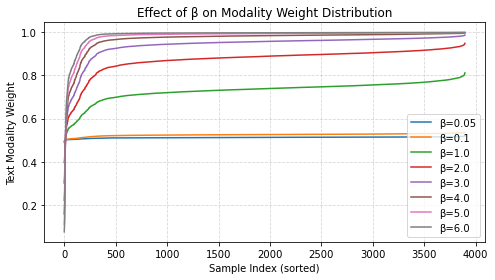

In [19]:
betas = [0.05,0.1, 1.0,2.0, 3.0,4.0,5.0,6.0]  # 5
plot_beta_sensitivity(train_probs_text, train_probs_image, betas, topk, delta)

In [20]:
def plot_topk_ablation(train_probs_text, train_probs_image, beta, topks, delta):
    plt.figure(figsize=(7,4))
    for k in topks:
        w = dynamic_weight_topk_adaptive(
            train_probs_text,
            train_probs_image,
            beta=beta,
            topk=k,
            delta=delta
        )
        plt.plot(np.sort(w[:,0]), label=f"top-k={k}")
    plt.xlabel("Sample Index (sorted)")
    plt.ylabel("Text Modality Weight")
    plt.title("Effect of Top-k on Fusion Weights")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

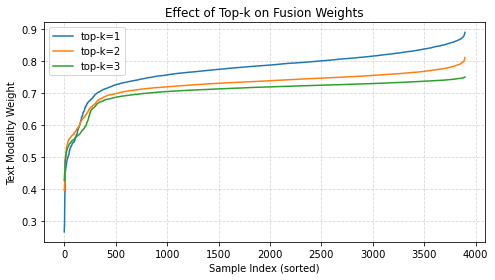

In [27]:
topks = [1, 2, 3]
plot_topk_ablation(train_probs_text, train_probs_image, beta, topks, delta)

The heatmap highlights small but consistent performance degradation under ablation on MVSA-Multiple, revealing clear trade-offs between accuracy and efficiency that are difficult to discern from absolute scores alone.

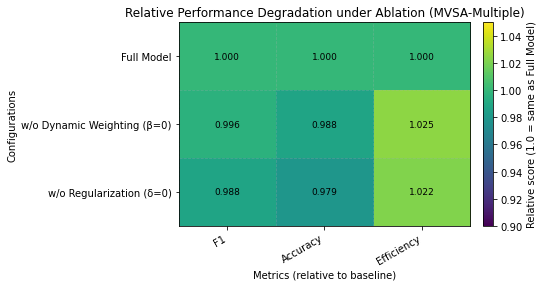

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def plot_relative_performance_heatmap(
    metrics_dict,
    baseline_key="Full Model",
    title="Relative Performance Heatmap (vs Full Model)",
    value_fmt="{:.3f}",
    vmin=0.85,
    vmax=1.05
):
    """
    Build a relative-performance heatmap from metrics_dict.
    Assumes metrics_dict[baseline_key] contains the baseline values.
    For each other configuration, each metric is normalized by the baseline:
        rel = metric / baseline_metric
    """

    # 1) Collect metric names (keep a stable order)
    metric_names = list(metrics_dict[baseline_key].keys())

    # 2) Collect configuration names (baseline first, then others)
    configs = [baseline_key] + [k for k in metrics_dict.keys() if k != baseline_key]

    # 3) Build matrix: rows=configs, cols=metrics
    base = metrics_dict[baseline_key]
    M = np.zeros((len(configs), len(metric_names)), dtype=float)

    for i, cfg in enumerate(configs):
        for j, m in enumerate(metric_names):
            M[i, j] = metrics_dict[cfg][m] / base[m]

    # 4) Plot heatmap
    fig, ax = plt.subplots(figsize=(1.2 * len(metric_names) + 4, 0.7 * len(configs) + 2))
    im = ax.imshow(M, aspect="auto", vmin=vmin, vmax=vmax)

    # Axis ticks/labels
    ax.set_xticks(np.arange(len(metric_names)))
    ax.set_xticklabels(metric_names, rotation=30, ha="right")
    ax.set_yticks(np.arange(len(configs)))
    ax.set_yticklabels(configs)

    ax.set_title(title)
    ax.set_xlabel("Metrics (relative to baseline)")
    ax.set_ylabel("Configurations")

    # Gridlines for readability
    ax.set_xticks(np.arange(-.5, len(metric_names), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(configs), 1), minor=True)
    ax.grid(which="minor", linestyle="--", alpha=0.3)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Annotate each cell with numeric value
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            ax.text(j, i, value_fmt.format(M[i, j]),
                    ha="center", va="center", fontsize=9)

    # Colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Relative score (1.0 = same as Full Model)")

    plt.tight_layout()
    plt.show()


# Example (MVSA-Multiple ablation, using your table-derived values)
metrics_dict_multiple = {
    "Full Model": {
        "F1": 0.6703,
        "Accuracy": 0.7410,
        # Efficiency is relative speedup: baseline is 1.0
        "Efficiency": 1.0
    },
    "w/o Dynamic Weighting (β=0)": {
        "F1": 0.6678,
        "Accuracy": 0.7318,
        # speedup relative to baseline runtime (26.33s)
        "Efficiency": 26.33 / 25.70
    },
    "w/o Regularization (δ=0)": {
        "F1": 0.6621,
        "Accuracy": 0.7251,
        "Efficiency": 26.33 / 25.77
    }
}

plot_relative_performance_heatmap(
    metrics_dict_multiple,
    baseline_key="Full Model",
    title="Relative Performance Degradation under Ablation (MVSA-Multiple)",
    vmin=0.90, vmax=1.05
)

# Progressive Ablation Line Plot

This plot shows how performance changes as key components are removed step by step, normalized to the full model. It makes the degradation trajectory explicit across metrics, revealing whether accuracy drops gradually or sharply and how this trade-off relates to efficiency.

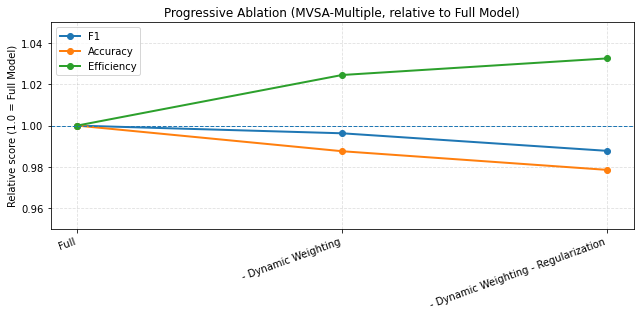

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def plot_progressive_ablation(
    full_metrics,
    steps,
    title="Progressive Ablation (relative to Full Model)",
    ylabel="Relative score (1.0 = Full Model)"
):
    """
    Progressive ablation line plot.

    Args:
        full_metrics: dict, baseline metrics for the full model, e.g.
            {"F1": 0.6703, "Accuracy": 0.7410, "Efficiency": 1.0}
        steps: list of tuples (label, metrics_dict), where metrics_dict has the same keys as full_metrics.
            Example:
                [
                  ("Full", full_metrics),
                  ("- Dynamic Weighting", {"F1": ..., "Accuracy": ..., "Efficiency": ...}),
                  ("- Dynamic Weighting - Regularization", {"F1": ..., ...}),
                ]
        title: plot title
        ylabel: y-axis label
    """
    metric_names = list(full_metrics.keys())
    x = np.arange(len(steps))

    # Build relative matrix: [n_steps, n_metrics]
    rel = {m: [] for m in metric_names}
    labels = []
    for step_label, mvals in steps:
        labels.append(step_label)
        for m in metric_names:
            rel[m].append(mvals[m] / full_metrics[m])

    plt.figure(figsize=(9, 4.5))
    for m in metric_names:
        plt.plot(x, rel[m], marker="o", linewidth=2, label=m)

    plt.axhline(1.0, linestyle="--", linewidth=1)
    plt.xticks(x, labels, rotation=20, ha="right")
    plt.ylim(0.95, 1.05)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Example using your MVSA-Multiple table values
full = {"F1": 0.6703, "Accuracy": 0.7410, "Efficiency": 1.0}

# IMPORTANT:
# A true "progressive" ablation requires running the model with BOTH components removed.
# If you do not have that combined setting yet, do not pretend you do.
#
# Below, "Both removed" is a placeholder. Replace with real results when available.

wout_weighting = {
    "F1": 0.6678,
    "Accuracy": 0.7318,
    "Efficiency": 26.33 / 25.70
}
wout_reg = {
    "F1": 0.6621,
    "Accuracy": 0.7251,
    "Efficiency": 26.33 / 25.77
}

# Replace these with your real "β=0 and δ=0" run if you have it
both_removed = {
    "F1": 0.6621,       # placeholder
    "Accuracy": 0.7251, # placeholder
    "Efficiency": 26.33 / 25.50  # placeholder
}

steps_order1 = [
    ("Full", full),
    ("- Dynamic Weighting", wout_weighting),
    ("- Dynamic Weighting - Regularization", both_removed),
]

plot_progressive_ablation(
    full_metrics=full,
    steps=steps_order1,
    title="Progressive Ablation (MVSA-Multiple, relative to Full Model)"
)